In [1]:
trainingOHCA_fileName = "generatedPoints1_100000_subzone.csv"
candidateAED_fileName = "buildings_locations_subzone.csv"

In [2]:
import pandas as pd
import numpy as np
from haversine import haversine_vector, Unit
from haversine import haversine
from os import path
import scipy.sparse
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
from pulp import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt     
import seaborn as sns
from itertools import combinations
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score
import scipy
import scipy.cluster
from matplotlib import colors as mcolors
from skimage.io import imread
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
import time

In [3]:
def MCLP(S,OHCA_Cluster,AED_Cluster,d,P): #Input for MCLP to return the coordinates of AEDs to be placed
    
    # S is Distance beyond which is considered uncovered
    # P is the number of AEDs to be placed in that cluster 
    
    I = OHCA_Cluster.index.values.tolist() #Demand Node
    J = AED_Cluster.index.values.tolist() #Facility Node
    P = P
    #a = np.ones(len(OHCA_Cluster))
    
    # N is a list in which each item is a list of nodes within threshold distance of ith node
    N = [[j for j in J if d[i][j] < S] for i in I]
    #P = 2400 #Number of AEDs to be placed in this cluster
    
    #Optimization
    prob = LpProblem("MCLP",LpMaximize)
    x = LpVariable.dicts("x",J,0,1,cat="Integer")
    y = LpVariable.dicts("y",I,0,1,cat="Integer")
    #a = LpVariable.dicts("a",I,cat="Continuous")
    
    #Objective
    #prob += lpSum([a[i]*y[i] for i in I])
    prob += lpSum([y[i] for i in I])
    
    #Constraints
    for i in I:
        prob += lpSum([x[j] for j in N[i]]) >= y[i]
       # for j in N[i]:
            #if x[j] == 1:
                #prob += a[i] == 0.549*d[i][j]**-0.584
        #a[i] = [0.549*d[i][j]**-0.584 for j in N[i] if x[j] == 1]
        
    prob +=lpSum([x[j] for j in J]) == P

    #Solving
    #solver = getSolver('GUROBI')
    #prob.solve(solver)
    prob.solve(GUROBI(msg=0))
    
    x_soln = np.array([x[j].varValue for j in J])
    print ("OHCA Served is = ", value(prob.objective))
    AED_Chosen = pd.concat([AED_Cluster,pd.DataFrame(x_soln,columns=['x'])],axis=1)
    AED_Chosen = AED_Chosen[AED_Chosen['x'] == 1]
    AED_Chosen = AED_Chosen.drop(columns=['x'])
    return(AED_Chosen)

In [4]:
def kmeans_OHCA_AED(OHCA,AED,k=2): #k is the number of clusters chosen
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(OHCA)
    
    OHCA_Cluster_All = pd.concat([OHCA,pd.DataFrame(kmeans.labels_,columns = ["cluster"])],axis=1)
    AED_lable = kmeans.predict(AED)

    AED_Cluster_All = pd.concat([AED, pd.DataFrame(AED_lable,columns = ["cluster"])], axis=1)

    return OHCA_Cluster_All, AED_Cluster_All

In [5]:
# input: two clusters 
# output: All_AED_in_Cluster
def MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,k=2):
    OHCA1_clusters, candidateAED1_clusters = kmeans_OHCA_AED(OHCA1, candidateAED1,k)
    All_AED_in_Cluster=pd.DataFrame(columns=['LatAED', 'LongAED']) 
    for i in range(k):
        OHCA20a = OHCA1_clusters[OHCA1_clusters['cluster']==i][["LatOHCA","LongOHCA"]].reset_index(drop=True)
        candidateAED20a = candidateAED1_clusters[candidateAED1_clusters['cluster']==i][["LatAED","LongAED"]].reset_index(drop=True)
        if len(candidateAED20a)>0:
            d1 = haverDist(OHCA20a,candidateAED20a)
            sub_AED_df = MCLP(100,OHCA20a,candidateAED20a,d1,int(p_subzone/k))
            All_AED_in_Cluster=All_AED_in_Cluster.append(sub_AED_df)
        else: pass
    return All_AED_in_Cluster

In [6]:
def kmeansPlot(OHCA_Cluster_All, k):
    colours = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
    for i in range(k):
        plt.scatter(x=OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i].iloc[:,0], y= OHCA_Cluster_All[OHCA_Cluster_All["cluster"]==i].iloc[:,1], s=5, c=colours[i])

In [7]:
def haverDist(OHCA_Cluster,AED_Cluster):
    d = haversine_vector(list(zip(OHCA_Cluster.LatOHCA, OHCA_Cluster.LongOHCA)), list(zip(AED_Cluster.LatAED, AED_Cluster.LongAED)), Unit.METERS, comb=True).T
    return(d)

In [8]:
OHCA = pd.read_csv(trainingOHCA_fileName)
candidateAED = pd.read_csv(candidateAED_fileName)

P_count=OHCA['region'].value_counts()
len(P_count)

327

In [25]:
P_count

300    1966
273    1960
179    1646
105    1435
141    1428
       ... 
153      18
69       16
323      14
4         2
259       1
Name: region, Length: 327, dtype: int64

In [26]:
%%time

start_time = time.time()

ALL_AED= pd.DataFrame(columns=['LatAED', 'LongAED']) 
all_AED_num=9880
all_OHCA_num=97542

for subzone in range(1,333):

    if subzone not in (7, 8, 9,159,174,231, 239,259,283, 284, 287,301, 304, 305, 317, 323):
        p_subzone=int(P_count.at[subzone]*all_AED_num/all_OHCA_num)
        print(subzone, P_count.at[subzone], p_subzone )
        OHCA1=OHCA[OHCA['region']== subzone]
        OHCA1=OHCA1[['LatOHCA','LongOHCA']].reset_index(drop=True)
        candidateAED1 = candidateAED[candidateAED['region']==subzone].copy()
        candidateAED1 = candidateAED1[['LatAED','LongAED']].reset_index(drop=True)
        candidateAED1 = candidateAED1.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
        AED_sub =MCLP_in_Cluster(OHCA1,candidateAED1,p_subzone,2)
        ALL_AED=ALL_AED.append(AED_sub)
print("Time is --- %s seconds ---" % (time.time() - start_time))

1 219 22
OHCA Served is =  None
OHCA Served is =  None
2 153 15
OHCA Served is =  85.0
OHCA Served is =  44.0
3 199 20
OHCA Served is =  85.0
OHCA Served is =  94.0
4 2 0
OHCA Served is =  0.0
OHCA Served is =  0.0
5 151 15
OHCA Served is =  36.0
OHCA Served is =  67.0
6 153 15
OHCA Served is =  None
OHCA Served is =  None
10 179 18
OHCA Served is =  16.0
OHCA Served is =  34.0
11 523 52
OHCA Served is =  102.0
OHCA Served is =  None
12 29 2
OHCA Served is =  12.0
OHCA Served is =  8.0
13 117 11
OHCA Served is =  None
OHCA Served is =  None
14 507 51
OHCA Served is =  80.0
OHCA Served is =  172.0
15 186 18
OHCA Served is =  50.0
OHCA Served is =  97.0
16 46 4
OHCA Served is =  19.0
OHCA Served is =  20.0
17 217 21
OHCA Served is =  99.0
OHCA Served is =  86.0
18 102 10
OHCA Served is =  48.0
OHCA Served is =  43.0
19 23 2
OHCA Served is =  12.0
OHCA Served is =  8.0
20 53 5
OHCA Served is =  19.0
OHCA Served is =  19.0
21 155 15
OHCA Served is =  74.0
OHCA Served is =  67.0
22 411 41
O

OHCA Served is =  398.0
OHCA Served is =  496.0
151 640 64
OHCA Served is =  301.0
OHCA Served is =  308.0
152 797 80
OHCA Served is =  379.0
OHCA Served is =  380.0
153 18 1
OHCA Served is =  0.0
OHCA Served is =  0.0
154 368 37
OHCA Served is =  140.0
OHCA Served is =  206.0
155 605 61
OHCA Served is =  285.0
OHCA Served is =  98.0
156 1257 127
OHCA Served is =  659.0
OHCA Served is =  387.0
157 344 34
OHCA Served is =  120.0
OHCA Served is =  83.0
158 405 41
OHCA Served is =  153.0
OHCA Served is =  157.0
160 403 40
OHCA Served is =  None
OHCA Served is =  14.0
161 189 19
OHCA Served is =  83.0
OHCA Served is =  60.0
162 669 67
OHCA Served is =  281.0
OHCA Served is =  375.0
163 437 44
OHCA Served is =  166.0
OHCA Served is =  235.0
164 1147 116
OHCA Served is =  574.0
OHCA Served is =  548.0
165 156 15
OHCA Served is =  66.0
OHCA Served is =  69.0
166 138 13
OHCA Served is =  23.0
OHCA Served is =  49.0
167 203 20
OHCA Served is =  83.0
OHCA Served is =  57.0
168 430 43
OHCA Served

OHCA Served is =  209.0
307 323 32
OHCA Served is =  145.0
OHCA Served is =  157.0
308 443 44
OHCA Served is =  206.0
OHCA Served is =  88.0
309 298 30
OHCA Served is =  103.0
OHCA Served is =  98.0
310 306 30
OHCA Served is =  43.0
OHCA Served is =  None
311 80 8
OHCA Served is =  17.0
OHCA Served is =  10.0
312 789 79
OHCA Served is =  335.0
OHCA Served is =  364.0
313 257 26
OHCA Served is =  105.0
OHCA Served is =  114.0
314 312 31
OHCA Served is =  64.0
OHCA Served is =  47.0
315 134 13
OHCA Served is =  36.0
OHCA Served is =  51.0
316 174 17
OHCA Served is =  52.0
OHCA Served is =  59.0
318 198 20
OHCA Served is =  54.0
OHCA Served is =  71.0
319 95 9
OHCA Served is =  2.0
OHCA Served is =  5.0
320 330 33
OHCA Served is =  None
321 335 33
OHCA Served is =  134.0
OHCA Served is =  82.0
322 167 16
OHCA Served is =  21.0
OHCA Served is =  65.0
324 278 28
OHCA Served is =  None
OHCA Served is =  86.0
325 923 93
OHCA Served is =  None
OHCA Served is =  None
326 1414 143
OHCA Served is

In [ ]:
# New computing time
# Time is --- 90.73087239265442 seconds ---
# Wall time: 1min 30s

In [27]:
print('The final Kmeans-MCLP AED result is in this dataframe below: ')
ALL_AED

The final Kmeans-MCLP AED result is in this dataframe below: 


LatAED     LongAED
0    1.293037  103.837773
4    1.294161  103.838058
30   1.294685  103.841406
85   1.293294  103.840845
89   1.291955  103.839607
..        ...         ...
223  1.354409  103.846451
244  1.353233  103.847712
254  1.354723  103.844875
0    1.266342  103.622595
51   1.277594  103.637965

[8257 rows x 2 columns]

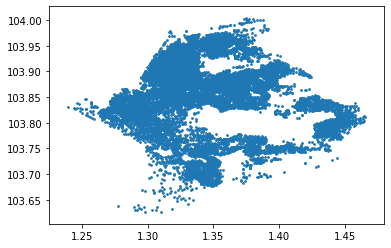

In [10]:
ALL_AED.to_csv('MCLP-MultiArea-KMeans-AED-Solution.csv')
plt.scatter(
   ALL_AED['LatAED'], 
   ALL_AED['LongAED'],s=3
)

In [ ]:
######################################################################################################
#Metrics
######################################################################################################

In [28]:
def totalCoverage(ohca_df, aed_df, MAX_DIST_METERS = 100):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000
    
    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 100, 'isCovered'] = 'covered'
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] > 100,'isCovered'] = 'uncovered'
    # each OHCA having an AED within 100m has isCovered = 'covered', otherwise 'uncovered'
    #print(cp_ohca)
    
    
    within_100m  = sum(cp_ohca['isCovered'] == 'covered')
    outside_100m = len(cp_ohca) - within_100m
    total_coverage_within_100m = within_100m / (within_100m + outside_100m)
    print("total coverage = ", total_coverage_within_100m)
    
    return total_coverage_within_100m

def partial_coverage(ohca_df, aed_df, ALPHA = 0.05):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] <= 20,'p_ij_coverage'] = 1.0
    cp_ohca.loc[cp_ohca['dist_nearest_AED'] >= 100,'p_ij_coverage'] = 0.0
    cp_ohca.loc[(cp_ohca['dist_nearest_AED'] < 100) & (cp_ohca['dist_nearest_AED'] > 20),
                'p_ij_coverage'] = np.exp(- ALPHA * (cp_ohca['dist_nearest_AED'] - 20))
    # p_ij of each OHCA calulated
    # print(cp_ohca)
    
    return cp_ohca['p_ij_coverage'].mean()

def expectedsurvival(OHCA,AED):
    prob = 0
    for i in range(len(OHCA)):
        survival = haversine_vector((OHCA.LatOHCA[i], OHCA.LongOHCA[i]), list(zip(AED.LatAED, AED.LongAED)), Unit.METERS, comb=True).T[0]
        survival = survival/(6.15*1000/60)*2
        survival = [p if np.isnan(p) == False else 0 for p in survival]
        survival = [1 if p<=1 and p != 0 else p for p in survival]
        survival = [p if p<20 else 0 for p in survival]
        survival = [p if p==0 or p == 1 else ((p**-0.584)*0.549) for p in survival]
        prob += max(survival)
    expectedSurvival = prob/len(OHCA)
    return(expectedSurvival)

In [29]:
def average_distance(ohca_df, aed_df):
    def ClosestAED(r):
        # Cartesian Distance: square root of (x2-x1)^2 + (y2-y1)^2
        distances = ((r['LatOHCA']-aed_df['LatAED'])**2 + (r['LongOHCA']-aed_df['LongAED'])**2)**0.5

        # AED with minimum Distance from the OHCA
        closestAEDId = distances[distances == distances.min()].index.to_list()[0]
        return aed_df.loc[closestAEDId, ['LatAED', 'LongAED']]

    cp_ohca = ohca_df.copy()
    cp_ohca[['ClosestAEDLatitude', 'ClosestAEDLongtitude']] = cp_ohca.apply(ClosestAED, axis=1)
    
    def haversine_np(lat1, lon1, lat2, lon2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = 6367 * c
        return km * 1000

    cp_ohca['dist_nearest_AED'] = haversine_np(cp_ohca['LatOHCA'], cp_ohca['LongOHCA'],
                                               cp_ohca['ClosestAEDLatitude'], cp_ohca['ClosestAEDLongtitude'])
    # distance to nearest AED (in metres) is recorded for each OHCA
    
    
    return cp_ohca['dist_nearest_AED'].mean()

In [30]:
AED_Chosen_All_MCLP=ALL_AED.reset_index(drop=True)
#AED_Chosen_All_MCLP = pd.read_csv("MCLP_SingleBest_Output.csv",index_col=0)
#total coverage 
MCLP_TC = totalCoverage(OHCA,AED_Chosen_All_MCLP,100)
print("MCLP total coverage is : ", MCLP_TC)
#partial coverage
MCLP_PC = partial_coverage(OHCA,AED_Chosen_All_MCLP)
# print("MCLP partial coverage is : ", MCLP_PC)
# #expected survival
MCLP_ES = expectedsurvival(OHCA,AED_Chosen_All_MCLP)
print("MCLP expected survival is : ", MCLP_ES)
#average distance to nearest AED
MCLP_AD = average_distance(OHCA, AED_Chosen_All_MCLP)
print("MCLP average distance is : ", MCLP_AD)

total coverage =  0.6616681215446647
MCLP total coverage is :  0.6616681215446647
MCLP expected survival is :  0.48585397097264404
MCLP average distance is :  163.57964207632915


In [31]:
print("MCLP partial coverage is : ", MCLP_PC)

MCLP partial coverage is :  0.14763584949013503
